## Packages for keyword extraction
- gensim: A library for topic modeling, which can also be used for extracting key phrases using the TextRank algorithm.
- nltk: The Natural Language Toolkit provides various tools and algorithms for natural language processing, including key phrase extraction.
- spaCy: A powerful library for natural language processing, which includes functionality for extracting key phrases.
- summa: A library specifically designed for text summarization, but it also includes a keyword extraction module that can be used for extracting key phrases.
- pytextrank: A Python implementation of the TextRank algorithm, which can be used for key phrase extraction.
- yake: 
- kpminer:  
- pke: 

##### Unsupervised graph based Keyword Extraction Models 
- TextRank
- SingleRank
- TopicRank
- TopicalPageRank
- PositionRank
- MultipartiteRank

##### statistical keyword extraction models 
- TF-IDF
- KPMiner
- YAKE!

##### data processing packages used. 
- pandas, polars , contractions, symspellpy


##### network visuzalization 
- networkx
- pyvis 
- gravis 


In [2]:

cfg = {'data_path':'/home/zjc1002/Mounts/data/cfpb/cfpb_complaints.csv'
       , 'cache_dir':"/home/zjc1002/Mounts/temp/"
       , 'project_root': '/home/zjc1002/Mounts/code/key_phrase_tracking'
       , 'incols':['Date received', 'Product','Consumer complaint narrative','Company public response']
       , 'text_cols':['Consumer complaint narrative','Company public response']

       , 'spell_correct_model_url': "https://haptik-website-images.haptik.ai/spello_models/en_large.pkl.zip"
       , 'spacy_model_path' : "en_core_web_lg"
       , 'stop_words_add':['my','xxxxxxxx','xxxx','xxx','xx']
       , 'stop_grams_add': ['mailbox_full']
       }


#manually download spacy model to disk for use in future 
cache_dir= cfg['cache_dir']
spacy_model_path=cfg['spacy_model_path']
spell_correct_model_url = cfg['spell_correct_model_url']

incols = ['Date received', 'Product','Consumer complaint narrative','Company public response']
text_cols = ['Consumer complaint narrative','Company public response']
n_samp = 1000



In [12]:
import pandas as pd
import polars as pl
from spello.model import SpellCorrectionModel
import io, re, string, spello,requests , zipfile, os, nltk, spacy , pytextrank, sys, math, logging, datetime
from pathlib import Path
from bs4 import BeautifulSoup # For removing HTML
import contractions # For expanding contractions
from unidecode import unidecode # For handling accented words
from fuzzywuzzy import process
from functools import reduce
from scipy.stats import t , chi2

import yake 
from  typing import List
import itertools
import collections
from collections import defaultdict

import nltk
from nltk import ngrams 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

sys.path.append(cfg['project_root'])
from utils import download_and_unzip, map_stems_to_orig, get_top_idf_terms, incorp_static_phrases, nearest, build_wordfreq_stat_dict
from polars_utils import prep_data, preprocess_text, remove_duplicate_words, ngram_phraser
#logger
logger = logging.getLogger(__name__)
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

[nltk_data] Downloading package punkt to /home/zjc1002/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/zjc1002/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
#stemmer 
stemmer = PorterStemmer()

#download stopwords
#nltk.download('stopwords')
#from nltk.corpus import stopwords # For removing stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords= set([str(s_t_r).lower() for s_t_r in list(stopwords) + cfg['stop_words_add'] if str(s_t_r).lower() not in ['up','down']])
stopgrams = cfg['stop_grams_add']

#download spacy model 
if not os.path.exists(Path(cache_dir,spacy_model_path).as_posix()):
    spacy.cli.download(spacy_model_path)

#load spacy model 
nlp = spacy.load(spacy_model_path)
nlp.to_disk(os.path.join(cache_dir,spacy_model_path))
nlp = spacy.load(os.path.join(cache_dir,spacy_model_path))
nlp.add_pipe('textrank')


#download the spell correction model (just copy in paste if behind firewall) 
if os.path.exists(cache_dir):
    print("The spell check model folder exists.")
else:
    download_and_unzip(spell_correct_model_url, cache_dir)

#spell correction model, we dont use it 
sp = SpellCorrectionModel(language='en')
sp.load(Path(cache_dir,spell_correct_model_url.split('/')[-1].replace('.zip','')))
sp.config.min_length_for_spellcorrection = 4

The spell check model folder exists.


/home/zjc1002/envs/key_phrase_extraction/lib/python3.11/site-packages/spello/model.py:301: UserWarning: This model was saved on spell<1.3.0. As such due to a bug in previous versions, none of customisations made to the config at the time of training were saved along with the model. It is recommended to load the model, apply all required customizations to config and save it again. E.g.

from spello.model import SpellCorrectionModel 
sp = SpellCorrectionModel(language='en')  
sp.load('/home/ubuntu/model.pkl')
sp.config.min_length_for_spellcorrection = 4 # default is 3
sp.config.max_length_for_spellcorrection = 12 # default is 15
sp.save(model_save_dir='/home/ubuntu/')

After this the model will load without any warnings

  warnings.warn("This model was saved on spell<1.3.0. As such due to a bug in previous versions, "


In [5]:




#spacy keyword extraction
def get_keywords_using_spacy(text: str, pos_tag: List[str] = ['PROPN', 'ADJ', 'NOUN']) -> List[str]:
    """
    Extracts keywords from the given text using spaCy.

    Args:
        text (str): The input text from which keywords need to be extracted.
        pos_tag (List[str], optional): The list of part-of-speech tags to consider as keywords.
            Defaults to ['PROPN', 'ADJ', 'NOUN'].

    Returns:
        List[str]: The list of extracted keywords.

    """
    doc = nlp(text)

    # Set the hot words as the words with pos tag “PROPN“, “ADJ“, or “NOUN“. (POS tag list is customizable)
    keywords = ([token.text for token in doc if token not in stopwords if not token.is_punct if token.pos_ in pos_tag])

    return keywords


### Option 2: PyTextRank  keyword exrtraction
def get_topN_keywords_TextRank(text: str, max_len: int = 4, top_N: int = 20):
    """
    Extracts the top N keywords from the given text using TextRank algorithm.

    Parameters:
    text (str): The input text from which keywords will be extracted.
    max_len (int): The maximum length of the keyword (in words). Default is 4.
    top_N (int): The number of top keywords to be extracted. Default is 20.

    Returns:
    list: A list of the top N extracted keywords.
    """
    
    doc = nlp(text)
    
    # keeping tri-grams
    keywords = [keyword.text for keyword in doc._.phrases if len(keyword.text.split()) <= max_len]
    
    # Remove duplicate keywords with customized threshold
    unique_keywords = list(process.dedupe(keywords, threshold=80))
    extracted_keywords = unique_keywords[:top_N]
    
    return extracted_keywords


def nltk_ngram_summary_from_polars(df, nltk_grams_colname='nltk_bigrams', top_n=5):
    """
    Generate a summary of the most common n-grams in a Polars DataFrame.

    Args:
        df (polars.DataFrame): The input Polars DataFrame.
        nltk_grams_colname (str, optional): The name of the column containing the NLTK n-grams. Defaults to 'nltk_bigrams'.
        top_n (int, optional): The number of most common n-grams to return. Defaults to 5.

    Returns:
        list: A list of tuples representing the most common n-grams and their counts.
    """
    
    #convert dataframe values back into list of tuples (or list of lists where each inner list is a 2 element list of bigram components)
    terms = [x.to_list() for x in df[nltk_grams_colname]]
    
    # Create counter of words in clean bigrams
    gram3_list = [(t[0],t[1]) for t in itertools.chain(*terms)]
    gram3_counts = collections.Counter(gram3_list)

    return gram3_counts.most_common(top_n)


def get_topN_keywords_YAKE(text: str, top_N: int) -> str:
    """
    Extracts the top N keywords from the given text using the YAKE keyword extraction algorithm.

    Parameters:
    text (str): The input text from which keywords need to be extracted.
    top_N (int): The number of top keywords to be extracted.

    Returns:
    str: A string containing the extracted keywords separated by commas.
    """
    
    # specifying parameters
    language = "en"
    max_ngram_size = 3
    deduplication_threshold = 0.75
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = top_N

    custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                                n=max_ngram_size, 
                                                dedupLim=deduplication_threshold, 
                                                dedupFunc=deduplication_algo, 
                                                windowsSize=windowSize
                                                , top=numOfKeywords
                                                )
    
    keywords_with_scores = custom_kw_extractor.extract_keywords(text)
    keywords = [x[0] for x in keywords_with_scores]
    
    # Remove duplicate keywords with customized threshold
    unique_keywords = list(process.dedupe(keywords, threshold=75))
    extracted_keywords = ", ".join(unique_keywords)
    
    return extracted_keywords





### Preprocess Text

In [6]:
# Read the CSV file into a polars DataFrame (and take a sample)
df = (pl.read_csv(cfg['data_path'], has_header=True)[incols]).drop_nulls(subset=text_cols).sample(n_samp)

# Create a new column 'input_txt' by concatenating 'Consumer complaint narrative' and 'Company public response'
df = (df.with_columns(pl.concat_str([pl.col('Consumer complaint narrative')
                                    , pl.col('Company public response')]).alias('input_col'))
                                    ).select(pl.col("*").exclude(text_cols))

#sent tokenize
df = df.with_columns(sent_tokenized = pl.col("input_col").map_elements(
    sent_tokenize, strategy= 'thread_local'))

#word tokenize and clean v
stem_map = map_stems_to_orig([word_tokenize(' '.join(sent.to_list()
                                                     ).lower()) for sent in  df['sent_tokenized'] ], stemmer) 


#stem_map = map_stems_to_orig([word_tokenize(sent.to_list()) for sent in  df['sent_tokenized'] ])
df = df.with_columns(word_tokenized = pl.col("sent_tokenized").map_elements(
    lambda x: [word_tokenize(preprocess_text(sent)) for sent in  x ] , strategy= 'thread_local'))

df = df.with_columns(input_col_clean = pl.col('input_col').map_elements(lambda x: preprocess_text(x)))
df.glimpse()

/tmp/ipykernel_1040622/675369940.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(sent_tokenized = pl.col("input_col").map_elements(
/tmp/ipykernel_1040622/675369940.py:19: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(word_tokenized = pl.col("sent_tokenized").map_elements(
/home/zjc1002/Mounts/code/key_phrase_tracking/polars_utils.py:37: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the f

Rows: 1000
Columns: 6
$ Date received               <str> '08/21/2018', '07/02/2017', '05/30/2017', '09/08/2017', '08/14/2018', '07/08/2015', '02/02/2016', '12/02/2015', '11/08/2017', '03/02/2018'
$ Product                     <str> 'Credit card or prepaid card', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Checking or savings account', 'Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Debt collection', 'Mortgage', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports'
$ input_col                   <str> 'I have a hard inquiry on my credit file, I did not permit this, or know what it is about. I have tried contacting them, but they tell me to contact XXXX XXXX, and then they keep running me back and forthCompany has resp

### Phrase Generation Techniques 

##### Option 1: Spacy (unigram monitoring)

In [6]:
#spacy ngrams (unigrams)
df = df.with_columns(spacy_keywords = pl.col('input_col_clean').map_elements(get_keywords_using_spacy, strategy= 'thread_local'))

#plot counts over time 
#spcy_df = prep_data(df.explode('spacy_keywords'), agg_by = ['Product'], count_of='keywords',datecol='Date received')

/tmp/ipykernel_5515/1936169579.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(spacy_keywords = pl.col('input_col_clean').map_elements(get_keywords_using_spacy, strategy= 'thread_local'))


##### Option 2: PyTextRank

In [8]:
#get keywords 
df = (df.with_columns(pytxtrnk_keywords = pl.col('input_col_clean').map_elements(get_topN_keywords_TextRank)))
#correct spelling (idk if this is worth it.... not required)
#WARNING: dont spell correct until all substtitution has occured 
#).with_columns(pl.col('pytxtrnk_keywords').map_elements(lambda x: [correct_spelling(sp,xx) for xx in x]))

#prep counts over time zjc
# pytxtrnk_df_cnts = prep_data(df.explode('pytxtrnk_keywords'), agg_by = ['Product'], count_of='keywords2',datecol='Date received')

/tmp/ipykernel_3544/3204275524.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = (df.with_columns(pytxtrnk_keywords = pl.col('input_col_clean').map_elements(get_topN_keywords_TextRank)))


##### Option 3: ngrams from nltk

In [9]:
df= df.with_columns(nltk_bigrams = pl.col('input_col_clean').map_elements(lambda x: [t for t in list(ngrams(x.split(' '),2))]))
df= df.with_columns(nltk_bigrams_str = pl.col('input_col_clean').map_elements(lambda x: [f"{t[0]} {t[1]}" for t in list(ngrams(x.split(' '),2))]))

#summary of top bigrams found by nltk ngram approach  
top_bigrams_by_product = {Product: nltk_ngram_summary_from_polars(df.filter(pl.col('Product')==Product),nltk_grams_colname = 'nltk_bigrams',top_n  = 5) for Product in df['Product'].unique()}

/tmp/ipykernel_3544/863464384.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df= df.with_columns(nltk_bigrams = pl.col('input_col_clean').map_elements(lambda x: [t for t in list(ngrams(x.split(' '),2))]))
/tmp/ipykernel_3544/863464384.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df= df.with_columns(nltk_bigrams_str = pl.col('input_col_clean').map_elements(lambda x: [f"{t[0]} {t[1]}" for t in list(ngrams(x.split(' '),2))]))


### Option 4: Yake 

In [7]:
df = df.with_columns(yake_keywords = pl.col('input_col_clean').map_elements(lambda x : get_topN_keywords_YAKE(x, 5).split(',')))

/tmp/ipykernel_1040622/2413456204.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(yake_keywords = pl.col('input_col_clean').map_elements(lambda x : get_topN_keywords_YAKE(x, 5).split(',')))


### Ngram Tracking Process 
1. Incorporating Key Phrases into text 
2. Calculating co-occurances and statistical measures to identify the most informative ngrams to monitor 
3. Calucating frequency of occurance over time for each selected ngram 

In [8]:
from operator import add, concat, iconcat
from itertools import chain
#if you want to create unigrams from the ngrams identified from one of above processes 
incorp_grams_2_txt = True
if incorp_grams_2_txt: 
    
 
    df = df.with_columns(pl.struct(['word_tokenized','yake_keywords']).map_elements(
        
            lambda x: list(chain.from_iterable([[word_tokenize(' '.join(x['word_tokenized'][i]).replace(y,y.replace(' ','_'))) for y in x['yake_keywords']] for i in range(0,len(x['word_tokenized']))]))

    ).alias('word_tokens'))
        

/tmp/ipykernel_1040622/3499395635.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.struct(['word_tokenized','yake_keywords']).map_elements(


In [39]:
#EXAMPLE USAGE 

ngram_len = 2
min_freq = 10 
score_method = 'PMI'
pmi_thresh = .5





ngram_phraser(df['word_tokens']
              , score_method = 'PMI'
              , ngram_len =3
              , min_freq=10
              , tthresh=.01
              , pmi_thresh =.55)


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


(shape: (787, 4)
 ┌───────────┬────────────────────────┬──────────┬────────────┐
 │ PMI       ┆ ngram                  ┆ N-PMI    ┆ ngram_freq │
 │ ---       ┆ ---                    ┆ ---      ┆ ---        │
 │ f32       ┆ str                    ┆ f64      ┆ i64        │
 ╞═══════════╪════════════════════════╪══════════╪════════════╡
 │ 26.264364 ┆ bkpt_ct_va             ┆ 1.838058 ┆ 16         │
 │ 25.836655 ┆ dear_sir_madam         ┆ 1.770998 ┆ 13         │
 │ 24.70006  ┆ xxxxxx_xxxxxx_xxxxxx   ┆ 1.739229 ┆ 17         │
 │ 23.208464 ┆ sp_select_portfolio    ┆ 1.6342   ┆ 17         │
 │ 23.175436 ┆ opportun_improv_better ┆ 1.621886 ┆ 16         │
 │ …         ┆ …                      ┆ …        ┆ …          │
 │ 3.804513  ┆ credit_report_would    ┆ 0.233561 ┆ 4          │
 │ 3.592275  ┆ account_report_credit  ┆ 0.258495 ┆ 21         │
 │ 3.330647  ┆ report_compani_report  ┆ 0.217843 ┆ 8          │
 │ 3.327901  ┆ credit_report_call     ┆ 0.204301 ┆ 4          │
 │ 2.710996  ┆ credit_r

### Time Series Control Limit Generation and ngram plots 

In [42]:

data = df 
DF_date = 'Date received'
DF_text = 'word_tokens' #word / sent tokenized 
start_date = datetime.datetime(2011,4,1)#'2015-04-01'
end_date =  datetime.datetime(2025,9,1) #'2015-05-01' #training end date 
cur_date =  datetime.datetime(2000,10,1)#'2015-10-01'
ngram_cutoff_periods = 3
ngram_pval_thresh = .01 
ngram_pmi_thresh = .7
max_tfidf_ngrams = 100 
rule1_topn = 15 

#control limit constants 
d2=1.128


#load data, format dates, and subset based on in scope date range 
data = (data.with_columns(date_col =pl.col(DF_date).str.to_datetime("%m/%d/%Y"))
        ).with_columns(pl.col('date_col').map_elements(
            lambda x: datetime.datetime(x.year,x.month,x.day)- datetime.timedelta(days=datetime.datetime(x.year,x.month,x.day).weekday()-4)
            if datetime.datetime(x.year,x.month,x.day).weekday() in [5,6] else datetime.datetime(x.year,x.month,x.day))
            ).sort(by='date_col'
                   ).filter(
                       (pl.col('date_col')>=start_date) & (pl.col('date_col')<=cur_date))


logger.debug(f"Dataframe shape after filtering: {data.shape}")
logger.debug(f"Dataframe contains ndates after filtering: {data.select(pl.col('date_col')).n_unique()}")

if data.shape[0]<1: 
    raise Exception(f"No data exists in date range specified. Data exists between {data.select(pl.col('date_col').min())} and {data.select(pl.col('date_col').max())} for reference")

#map stems 

#ngramcutoff
ngram_cutoff_date= sorted([v[0] for v in data.select('date_col').unique().to_numpy()])[-ngram_cutoff_periods]


#PMI
ngramTable_pmi, doc_to_ngram_pmi = ngram_phraser(
                                                [v for v in data.filter(pl.col('date_col')<= ngram_cutoff_date).select(['word_tokens'])][0]
                                                , score_method = 'PMI'
                                                , ngram_len =2
                                                , min_freq=3
                                                , pmi_thresh =ngram_pmi_thresh)


ngramTable_pmi = ngramTable_pmi.filter(pl.col('N-PMI')>=ngram_pmi_thresh).sort(by=['N-PMI','ngram_freq'],descending=True)


#Chi2
ngramTable_chi2, doc_to_ngram_chi2 = ngram_phraser(
                                                [v for v in data.filter(pl.col('date_col')<= ngram_cutoff_date).select(['word_tokens'])][0]
                                                , score_method = 'Chi_sq'
                                                , ngram_len =2
                                                , min_freq=3
                                                , tthresh =ngram_pval_thresh)


ngramTable_chi2 = ngramTable_chi2.filter(pl.col('p')<=ngram_pval_thresh).sort(by=['chi-sq','ngram_freq'],descending=True).head(200)

#ttest
ngramTable_ttest, doc_to_ngram_ttest = ngram_phraser(
                                                [v for v in data.filter(pl.col('date_col')<= ngram_cutoff_date).select(['word_tokens'])][0]
                                                , score_method = 'Student_t'
                                                , ngram_len =2
                                                , min_freq=7
                                                , tthresh =ngram_pval_thresh)


ngramTable_ttest = ngramTable_chi2.filter(pl.col('p')<=ngram_pval_thresh).sort(by=['p','ngram_freq'],descending=True).head(300)

#unigrams 
ngramTable_tfidf = get_top_idf_terms(data['word_tokens'].apply(lambda x: list(chain.from_iterable(x))).to_pandas(), topn=max_tfidf_ngrams
                                     , sent_tokenized=False, stopwords=[v for v in stopwords])
ngramTable_tfidf

#combine ngrams from all three approaches 
#filter out ngrams with stopgrams 
ngram_list = list(set(list(ngramTable_pmi['ngram']) + list(ngramTable_chi2['ngram']) + list(ngramTable_ttest['ngram']) + list(ngramTable_tfidf['term'])))
ngram_list_final = [s for s in ngram_list if all(xs.lower() not in s.lower() for xs in stopgrams)]
logger.info(f"{len(ngram_list)-len(ngram_list_final)} ngram removed due to stopgrams")
logger.info(f"ngram generation complete. {ngramTable_ttest['ngram'].n_unique()} ngrams generated from ttest, {ngramTable_chi2['ngram'].n_unique()} ngrams generated from chi2, {ngramTable_pmi['ngram'].n_unique()} ngrams generated from pmi, and {len(ngramTable_tfidf['term'].unique())} ngrams generated from tfidf")
logger.info(f"total of {len(ngram_list_final)} ngrams generated after filtering out stopgrams")


#incorporate static ngrams into text 
logger.info(f"ngram substitution begining for {len([len(ngram.split('_')) for ngram in ngram_list_final if len(ngram.split('_'))>1])}")
ngram_map_tups = [((' '.join(ngram.split('_'))),ngram) for ngram in ngram_list_final if len(ngram.split('_'))>1]


#incorp static phrases into document 
data = data.select([pl.col('*')
             , (pl.col('word_tokens').apply(lambda x:  incorp_static_phrases(' '.join([v for v in list(chain.from_iterable(x)) if v not in stopgrams]),ngram_map_tups).split())).alias('word_tokens2')])


#generate count freqs for each data and % of total freqs for each unigram 
count_stats_dict = defaultdict(dict)
for i,dt in enumerate(sorted(set([v for v in data.select('date_col').to_series()]))): 
    df_t = data.filter(pl.col('date_col')==dt).select([pl.col('word_tokens2')])
    if len(df_t)>2: 
        count_stats_dict[dt] = build_wordfreq_stat_dict(df_t)



#convert count stats from dict to df (index = key phrases, columns = date counts)
cnt_summary_df = pd.DataFrame.from_dict(count_stats_dict).fillna(0)


#Control limit start 
try: 
    start_date_train = pd._libs.tslib.Timestamp(start_date)
    start_date_train_idx = list(cnt_summary_df.columns>=start_date_train).index(True)
except Exception: 
    raise ValueError("An error occurred while processing the start date. Please ensure it's in the correct format.")



try:
    end_date_train  = pd._libs.tslib.Timestamp(end_date)

    if end_date_train < max(cnt_summary_df.columns):
        logger.info(f"end date {end_date_train} is prior to last date in data {max(cnt_summary_df.columns)}")
        end_date_train_idx = list(cnt_summary_df.columns>end_date_train).index(True)-1
    if end_date_train == max(cnt_summary_df.columns):
        logger.info(f"end date {end_date_train} is the last date in data {max(cnt_summary_df.columns)}")
        end_date_train_idx = list(cnt_summary_df.columns>= end_date_train).index(True)
    if end_date_train > max(cnt_summary_df.columns):
        logger.info(f"end date {end_date_train} is after last date in data {max(cnt_summary_df.columns)}")
        nearest_date_end = nearest(cnt_summary_df.columns, end_date_train) 
        logger.info(f"closest date to end date is {nearest_date_end}")
        end_date_train_idx = list(cnt_summary_df.columns>=nearest_date_end).index(True)
    
except Exception: 
    raise Exception("start and end date assignment failed")

#id current date, or date closest to current date 
cur_date_test = pd._libs.tslib.Timestamp(cur_date)

try: 
    cur_date_test_idx = cnt_summary_df.columns.get_loc(cur_date_test)
except: 
    nearest_date = nearest(cnt_summary_df.columns, cur_date_test)
    cur_date_test_idx = cnt_summary_df.columns.get_loc(nearest_date)



#filter 
DataDev = cnt_summary_df.iloc[:,start_date_train_idx:cur_date_test_idx+1].copy()
DataDev = DataDev.loc[ngram_list_final].fillna(0)

#control limit derived inputs (how long back to use in establishing means)
k = end_date_train_idx - start_date_train_idx + 1   # number of days to use in building control limits  
curIdx = cur_date_test_idx-start_date_train_idx     # index for current day in DataDev datafarme
showK = cur_date_test_idx - start_date_train_idx + 1 # tommorrows day in DataDev dataset (t+1)


#calculate x mean 
DataDev['x_bar'] = np.average(DataDev.iloc[:,:K],axis=1)

/tmp/ipykernel_1040622/3718186171.py:19: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ).with_columns(pl.col('date_col').map_elements(
DEBUG:__main__:Dataframe shape after filtering: (0, 9)
DEBUG:__main__:Dataframe contains ndates after filtering: 0


Exception: No data exists in date range specified. Data exists between shape: (1, 1)
┌──────────────┐
│ date_col     │
│ ---          │
│ datetime[μs] │
╞══════════════╡
│ null         │
└──────────────┘ and shape: (1, 1)
┌──────────────┐
│ date_col     │
│ ---          │
│ datetime[μs] │
╞══════════════╡
│ null         │
└──────────────┘ for reference

In [35]:
[v for v in ngram_list_final if 'reserv' in v]

['reserv_hotel',
 'reserv_senat',
 'feder_reserv_form_balanc_sheet',
 'preserv_specialist']

topterms

In [1]:
### MNAUAL VERSION

#generate list of all possible ngrams from docs 
document_ngram_list = [['_'.join(_sentence[i:i + ngram_len]) for _sentence in _document for i in range(len(_sentence) - ngram_len +1)] for _document in df['word_tokens']]
                      

#get word frequency and identify number of unique tokens in corpus 
corpus_len = 0 
word_freq_dict = defaultdict(int)
token_list = []

#generate word counts , tokens, and doc length 
for _list in df['word_tokens']: 
    for _sentence in _list: 
        for token in _sentence: 
            word_freq_dict[token]+=1
            corpus_len += 1
            token_list.append(token)

#get ngram frequency dictionary 
ngram_freq_dict = defaultdict(int)
ngram_doc_dict = defaultdict(list)
for i, _list in enumerate(document_ngram_list):
    for ngram in _list: 
        ngram_freq_dict[ngram]+=1
        ngram_doc_dict[ngram].append(i)
        
#use nltk collactions to try differnt scoring methods 
#bigrams using PMI as  metric 
if ngram_len == 2: 
    bigrams = nltk.collocations.BigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(token_list)
    bigramFinder.apply_freq_filter(min_freq)
    bigramFinder.apply_ngram_filter(invalid_ngram)

    if score_method == 'PMI':

        ngramTable = (pl.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi))
                                  , schema = {'ngram':pl.List(pl.String), 'PMI':pl.Float32}
                                  ).sort(by='PMI', descending=True)
                                  ).lazy(
                                      ).select(
                                                [   pl.col('*').exclude('ngram')
                                                    , pl.col('ngram').apply(lambda x: '_'.join(x)).alias('ngram')
                                                ]
                                            ).select(
                                                [ pl.col('*')
                                                 , (pl.col('PMI') /   pl.col('ngram').apply(lambda x: (-1*(math.log2(ngram_freq_dict[x]/corpus_len))))).alias('N-PMI')
                                                 , (pl.col('ngram').apply(lambda x: ngram_freq_dict[x])).alias('ngram_freq')
                                                ]
                                                ).collect()

    
#generate final output dic of ngrams mapped to docs 
doc_ngram_dict = defaultdict(list)
if score_method in ['PMI']: 
   for ngram in ngramTable.filter(pl.col('N-PMI')>pmi_thresh).select('ngram').iter_rows(): 
       print(ngram[0])
       for doc in ngram_doc_dict[ngram[0]]:
           doc_ngram_dict[doc].append(ngram[0])


#extract all ngram counts for each document in original input 
doc_to_ngram = [doc_ngram_dict[i] for i in range(len(df))]

NameError: name 'df' is not defined

In [215]:
pl.Series(name = 'preds', values = t.sf([.3214,25,223,65], len(ngram_freq_dict)-1))

preds
f64
0.373959
3.0151e-132
0.0
0.0


[15.100256,
 14.960341,
 14.9456835,
 14.675283,
 14.544629,
 14.358543,
 12.83926,
 12.704322,
 8.627367,
 8.361597,
 8.310585,
 7.20347,
 6.1693597,
 6.0297813,
 5.9824824,
 5.96705,
 5.8316474,
 5.736806,
 5.7156525,
 5.3602395,
 5.357035,
 5.273445,
 5.2709637,
 5.258849,
 4.893407,
 4.790688,
 4.751408,
 4.67654,
 4.6592116,
 4.5551753,
 4.5352,
 4.4553995,
 4.4248114,
 4.3900375,
 4.3438826,
 4.2445526,
 4.2368493,
 4.202033,
 4.1740036,
 4.1703267,
 4.167964,
 4.104815,
 4.0273337,
 4.018674,
 3.9897158,
 3.9875443,
 3.985521,
 3.95435,
 3.9251428,
 3.9245994,
 3.8937242,
 3.8710554,
 3.8670673,
 3.8619065,
 3.787054,
 3.7425818,
 3.6910872,
 3.6834955,
 3.6803033,
 3.6774154,
 3.647935,
 3.6257854,
 3.6193664,
 3.6098466,
 3.6030848,
 3.6004047,
 3.5961769,
 3.5676117,
 3.5387945,
 3.5381866,
 3.5342257,
 3.52146,
 3.5088227,
 3.5038378,
 3.5015934,
 3.4975357,
 3.4603863,
 3.4590354,
 3.4507322,
 3.4479177,
 3.4414442,
 3.424078,
 3.419828,
 3.4150183,
 3.4116654,
 3.4058392,


In [90]:
[ngram_doc_dict[item] for sublist in [n.to_list() for n in ngramTable.filter(pl.col('N-PMI')> pmi_thresh).select('ngram')] for item in sublist]

[[5, 5, 5, 5, 32, 32, 32, 32, 96, 96, 96],
 [34, 34, 34, 34, 34, 34, 34, 34, 34, 34],
 [47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47],
 [9, 9, 9, 14, 14, 14, 14, 48, 48, 48, 65, 65, 65, 69, 69, 69],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [5, 5, 5, 5, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 79, 79, 79, 79],
 [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  46,
  46,
  46],
 [59, 59, 59, 59, 68, 68, 68, 86, 86, 86],
 [5, 5, 5, 5, 68, 68, 68, 98, 98, 98, 98],
 [96, 96, 96, 96, 96, 96, 96, 96, 96, 96],
 [28, 28, 28, 33, 33, 33, 33, 33, 33, 33, 33, 86, 86, 86],
 [22, 22, 22, 22, 66, 66, 66, 66, 66, 66, 66, 72, 72, 72, 84, 84],
 [0, 0, 0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  26,
  26,
  26,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  85,
  85,
  85,
  85,
  

In [32]:
q = (
    ngramTable.lazy().select(
        [   pl.col('*').exclude('ngram')
            ,pl.col('ngram').apply(lambda x: '_'.join(x)).alias('ngram')
        ]
    )
)

#ngramTable['ngram'] =  ngramTable.select(pl.col('ngram').apply(lambda x: '_'.join(x)))
ngramTable.collect()

NameError: name 'x' is not defined

Rows: 100
Columns: 8
$ Date received                 <str> '09/15/2017', '06/04/2019', '05/01/2018', '11/10/2018', '08/26/2018', '02/12/2016', '12/03/2018', '10/09/2017', '03/23/2018', '10/18/2015'
$ Product                       <str> 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Mortgage', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit card', 'Debt collection', 'Credit reporting, credit repair services, or other personal consumer reports', 'Mortgage', 'Credit card'
$ input_col                     <str> 'author inquiri list pleas remov immedi co inquiri xxxx inquiri bankcard inquiri miscellan inquiri inquiri mail order inquiri bank inquiri bank inquiri xxxxl inquiri bank inquiri inquiri credit union inquiri specialti xxxx inquiri complet dept store inqu

In [119]:
import pandas as pd
# sklearn countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,3), min_df = .005 
                     , max_df = .8, stop_words = 'english')

all_text = [remove_duplicate_words(v) for v in pytxtrnk_df['keywords2']]

# matrix of token counts
X = cv.fit_transform(all_text)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
df.to_csv('to gephi.csv', sep = ',')

## plot the frequency of the top 5 co-occuring words associated with the latest emerging phrases

In [195]:

#spa
pytxtrnk_df = df.with_columns(keywords = pl.col('input_col').map_elements(get_topN_keywords_TextRank))
#                ).with_columns(pl.col('keywords').map_elements(lambda x: [correct_spelling(sp,xx) for xx in x]).alias('keywords2'))


pytxtrnk_df = pytxtrnk_df.with_columns(pl.struct(['input_col','keywords2']
                                                 ).map_elements(lambda x: ' '.join([x['input_col'].replace(y,y.replace(' ','_')) for y  in  x['keywords2']]).alias('zjc')))
    
    

#prep counts over time 
#pytxtrnk_df_cnts = prep_data(pytxtrnk_df.explode('keywords2'), agg_by = ['Product'], count_of='keywords2',datecol='Date received')
#pytxtrnk_df_cnts.head()

ColumnNotFoundError: keywords2

Error originated just after this operation:
DF ["Date received", "Product", "input_col", "keywords"]; PROJECT */4 COLUMNS; SELECTION: "None"

In [190]:
pytxtrnk_df.glimpse()

Rows: 100
Columns: 6
$ Date received       <str> '10/07/2017', '09/11/2017', '05/12/2016', '03/04/2018', '05/08/2018', '10/22/2018', '10/25/2018', '03/14/2016', '08/10/2016', '10/11/2016'
$ Product             <str> 'Vehicle loan or lease', 'Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Student loan', 'Mortgage', 'Bank account or service'
$ input_col           <str> 'servic mn may concern receipt us bank demand notic date us_bank_claim owe threaten legal remedi payment made i understand money traffic ticket surcharg charg made leas finish as state written correspond ticket receiv paid promptli ticket first sent us bank 

In [173]:
import itertools
import collections
from nltk import ngrams 

# Create list of lists containing bigrams 
ngram_max = 8
#list of strings 
cooccur_input = [x for x in df['input_col']]

#input: word tokenized list of words 
terms_3gram = [list(ngrams(words.split(' '), ngram_max)) for words in cooccur_input]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])

# Create counter of words in clean bigrams
gram3_list = list(itertools.chain(*terms_3gram))
gram3_counts = collections.Counter(gram3_list)
gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[('servic', 'mn'), ('mn', 'may'), ('may', 'concern'), ('concern', 'receipt'), ('receipt', 'us')]


[(('choos', 'provid'), 77),
 (('provid', 'public'), 77),
 (('public', 'respons'), 77),
 (('respond', 'consum'), 68),
 (('consum', 'cfpb'), 68)]

In [91]:
import networkx as nx
import warnings
import matplotlib.pyplot as plt

# Create network plot 
G = nx.Graph()


for _, row in word_pairs_count.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row[0])

#import statsmodels.api as sm
warnings.filterwarnings("ignore")
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))


d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]

nx.draw(G, pos_kkl, 
        with_labels=True, 
        node_size=[v * 100 for v in d.values()],
        nodelist=d.keys(),  
        width=weights, 
        edge_color='grey', #node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", 
        alpha=0.9,
       )
#node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
ax.set_title('Word Co-occurrence Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'salmon', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")


NameError: name 'word_pairs_count' is not defined

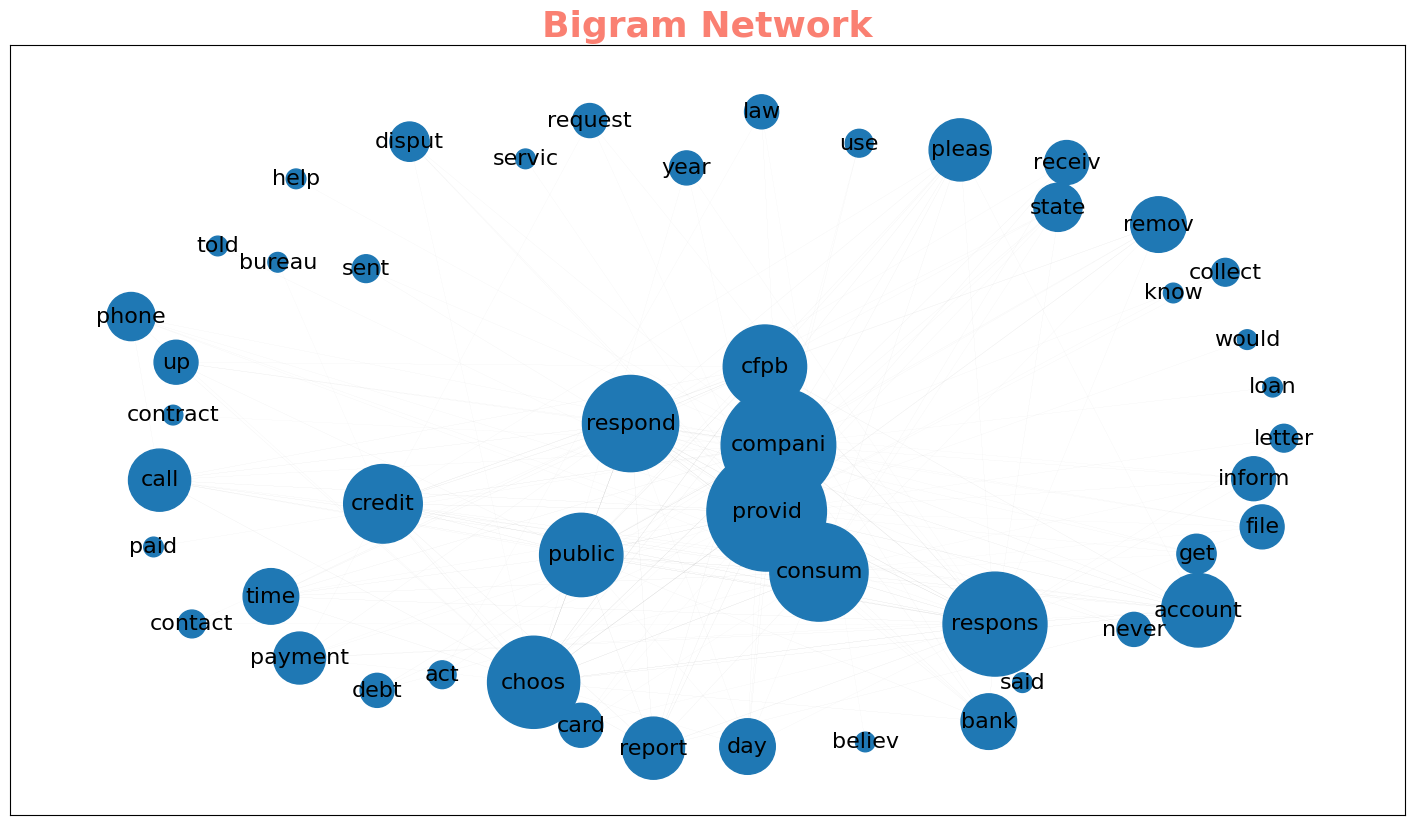

In [178]:
fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=8)

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 node_size = [v * 200 for v in d.values()], 
                 edge_color='grey',
                 #node_color='tomato',
                 with_labels = True,
                 ax=ax)

ax.set_title('Bigram Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'salmon', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')    
plt.show()



### Reference Material 
#### Manual Implementation of forward bi-gram string search 
```python
#all_text = [remove_duplicate_words(v) for v in pytxtrnk_df['keywords2']]
#cooccur_input = [remove_duplicate_words(x) for x in df['input_col']]
        
word_pairs = []
for words in cooccur_input:
    words_ = list(set(words.split(' ')))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs.append([word_i, word_j])
            else:
                word_pairs.append([word_i, word_j])



df_word_pairs = pd.DataFrame(data = word_pairs, columns=['word1', 'word2'])
word_pairs_count = df_word_pairs.groupby(['word1', 'word2']).size()
word_pairs_count = word_pairs_count.sort_values().tail(200).reset_index()
```
